In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table
station=Base.classes.station
measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date=session.query(measurement.date).order_by(measurement.date.desc()).first()

most_recent_date


('2017-08-23',)

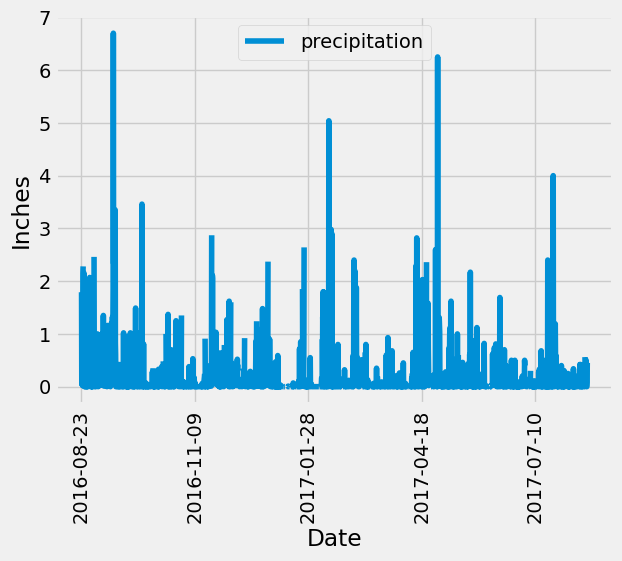

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago= dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data=session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
One_year_precipitation_df= pd.DataFrame(precipitation_data, columns=["date","precipitation"])

# Sort the dataframe by date
One_year_precipitation_df = One_year_precipitation_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
One_year_precipitation_df.plot(x="date",
                               y="precipitation", 
                               rot="vertical", 
                               xlabel="Date",
                               ylabel="Inches"
)


plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
One_year_precipitation_df.describe()#used built in function

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
#alternative: session.query(func.count(func.distinct(measurement.station))).all()
# join to make sure all station are represented
session.query(func.count(func.distinct(station.station)))\
    .join(measurement, station.station == measurement.station).all()


[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# query only the measurement table only
#station_activity=session.query(measurement.station,func.count()).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
#print(f'The most active station is: {station_activity[0][0]}'), 

#join station and measurement for  station and count so both table are included
station_activity=session.query(station.station, func.count(measurement.station))\
    .join(measurement, station.station == measurement.station).group_by(station.station)\
        .order_by(func.count(measurement.station).desc()).all()
print(f'The most active station is: {station_activity[0][0]}'),station_activity

The most active station is: USC00519281


(None,
 [('USC00519281', 2772),
  ('USC00519397', 2724),
  ('USC00513117', 2709),
  ('USC00519523', 2669),
  ('USC00516128', 2612),
  ('USC00514830', 2202),
  ('USC00511918', 1979),
  ('USC00517948', 1372),
  ('USC00518838', 511)])

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_temperature = session.query(
    func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs))\
        .filter(measurement.station == station_activity[0][0]).all()
most_active_station_temperature

[(54.0, 85.0, 71.66378066378067)]

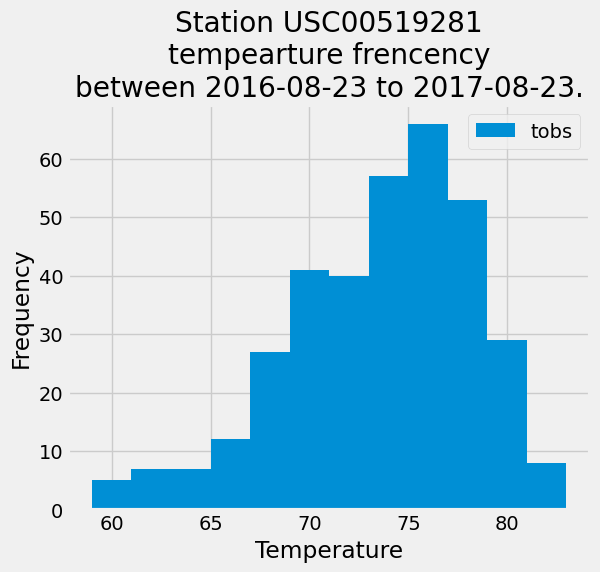

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_1yr= session.query(measurement.tobs).filter(measurement.station == station_activity[0][0], measurement.date >= one_year_ago).all()

station_temp_1yr_df= pd.DataFrame(station_temp_1yr, columns=["tobs"])

station_temp_1yr_df.plot(kind="hist",
                         figsize=(6,5),
                         bins=12,
                         xlabel="Temperature",
                         ylabel="Frequency",
                         title=f"Station {station_activity[0][0]}\ntempearture frencency\nbetween {one_year_ago} to {most_recent_date[0]}."
                         )
plt.show()

# Close Session

In [16]:
# Close Session
session.close()